# Tract similarity

In this notebook, we test the following hypothesis:

**Tracts can be ranked according to the similarity of brain regions that connect to it. This reflects the unimodal-to-transmodalness of tracts.**

Approach:

* Generate an affinity matrix that reflect the similarity of pairs of brain regions across selected cortical features. 
* Generate regions x regions "tract masks", where 1 indicates both regions are connecting to a given tract; 0 indicates that one or both regions are not connected.
* t-tests comparing the similarity of cortical features in connected vs unconnected regions.
* Comparison against shuffled tract-to-region probabilities. 
* A significant result would indicate that brain regions linked to this tract are more similar to each other compared to regions not connected to the tract.

In [1]:
# let's import the needed packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
from neuromaps.datasets import fetch_fslr, fetch_annotation
from neuromaps import datasets, images, nulls, resampling, stats, transforms, parcellate
from surfplot import Plot
from neuromaps.parcellate import Parcellater, _gifti_to_array
from neuromaps.resampling import resample_images
from neuromaps.images import dlabel_to_gifti
import neuromaps
import nibabel as nib
import os
import numpy as np
import mayavi
from PIL import Image
import hcp_utils as hcp
import nilearn.plotting as plotting
import tractmaps_utils
import snf
from sklearn import cluster
from snf import metrics
from scipy import stats as sstats
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import seaborn as sns

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Load data
Run the cortical features cell OR the neurosynth cell depending on which maps you want to run analyses on. 

In [2]:
### CORTICAL FEATURES DATA ###
analysis = 'cortex'
data = pd.read_csv('./inputs/tracts_maps_Glasser.csv')

In [2]:
### NEUROSYNTH DATA ###
analysis = 'neurosynth'
data = pd.read_csv('./inputs/tracts_neurosynth_Glasser.csv')

In [3]:
# set up inputs
maps_df = data.iloc[:, 59:]
maps_list = [maps_df[col].values for col in maps_df.columns]
map_names = list(maps_df)
glasser_maps = maps_df.to_dict(orient = 'list')
glasser_maps = {key: np.array(value) for key, value in glasser_maps.items()} # store parcellated maps as dictionary of map_names and arrays

## Test tract similarity

In [5]:
# define parameters
map_names = list(glasser_maps.keys())
tract_names = list(data.filter(regex = 'left|right').columns)
tract_names = [item for item in tract_names if item not in ['F_left', 'F_right']] # remove fornix (not used below)
n_tracts = len(tract_names)
df = data
connection_threshold = 0.95
nspins = 10000
testtype = 'twotailed'
glasser = tractmaps_utils.get_glasser() # load glasser parcellation GIFTI images (lh, rh)

In [6]:
def generate_mean_diff(tract_probs, tract_name, similarities_dict, connection_threshold = 0.95):
    """
    Generate difference in means of brain regions connected vs non-connected to a tract. 
    It first creates a tract connection masks based on an array of probabilities of connection across all brain regions (brain regions, 1).
    Next, it applies the mask to compute average values in connected vs non-connected brain regions for the chosen tract.

    Parameters:
    - tract_probs (np.array): Input array containing connection probabilities for all (360) brain regions in a given tract.
    - tract_name (string): Name of the tract corresponding to the input tract_probs array and for which the connection mask will be computed.
    - connection_threshold (float, optional): Threshold for binarizing tract connections. Default is 0.95.
    - similatities_dict (dictionary): Input dictionary containing similarity matrices (for example the output after applying snf.compute.make_affinity across several features) 
        for left and right hemispheres.

    Returns:
    - mean_diff: A value reflecting the difference in means between connected vs non-connected brain regions for a given tract.
    - t_stat: A t-value generated from an independent two-sample t-test comparing the means between connected vs non-connected brain regions for a given tract.
    
    """
    
    # select regions corresponding to the hemisphere the tract belongs to
    if 'left' in tract_name:
        sim_matrix = similarities_dict['Left']
        if tract_probs.ndim == 1: # single column is provided
            hem_tract_probs = tract_probs[:180] 
        else:
            print('Multiple columns detected (spins).')
            hem_tract_probs = tract_probs[:180, :] # multiple columns are provided (e.g. in the case of spins)
    elif 'right' in tract_name:
        sim_matrix = similarities_dict['Right']
        if tract_probs.ndim == 1:
            hem_tract_probs = tract_probs[180:]
        else:
            print('Multiple columns detected (spins).')
            hem_tract_probs = tract_probs[180:, :]

    
    # binarize tract connections based on threshold
    tract_mask = np.where(hem_tract_probs >= connection_threshold, 1, 0)

    # construct a connectivity matrix using the outer product (if both regions are connected to the tract, the matrix will have a 1 at that spot; otherwise, it's 0)
    tract_mask = np.outer(tract_mask, tract_mask)
    
    # create mask to only select upper triangle region pairs (avoids redundancy in symmetrical matrices)
    nnodes = len(sim_matrix)
    mask = np.triu(np.ones(nnodes), 1) > 0 # the 1 argument means skip the diagonal and extract all above it

    # generate daframe of multimap similarity values in connected vs non-connected regions (of spun connection map)
    d = dict({'connected' : sim_matrix[mask][np.where(tract_mask[mask] != 0)],
              'not connected' : sim_matrix[mask][np.where(tract_mask[mask] == 0)]})
    d = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in d.items()]))


    # Calculate mean of connected and non-connected regions of spun connection map
    connected_mean = d['connected'].mean(skipna = True)
    not_connected_mean = d['not connected'].mean(skipna = True)

    # Calculate the null difference in the means
    mean_diff = connected_mean - not_connected_mean 
    
    # Get t-value output from an independent t-test
    t_stat, _ = sstats.ttest_ind(d['connected'], d['not connected'], nan_policy = 'omit') # not getting p-value here as we use the p-value from spin testing
    
    return mean_diff, t_stat
 

In [7]:
import importlib
importlib.reload(tractmaps_utils)

<module 'tractmaps_utils' from '/Users/joelleba/neurohackademy/tractmaps/tractmaps_utils.py'>

In [199]:
# generate spins (shuffled tract probabilites)
tract_spins = {} # dictionary to store spun tract connection maps
for tract_name in tract_names:
#     tract_probs = df[tract_name].fillna(0)
    spins = nulls.alexander_bloch(tract_probs, atlas = 'fsLR', density = '32k', 
                                         n_perm = nspins, seed = 1234, parcellation = glasser)
    tract_spins[tract_name] = spins

# save tract spins
tractmaps_utils.save_data(tract_spins, f'./outputs/nulls/tract_probabilities_{nspins}spins.pickle')

In [6]:
# check the number of NaNs in spin samples for each tract
tract_spins = tractmaps_utils.load_data(f'./outputs/nulls/tract_probabilities_{nspins}spins.pickle')

for tract, data_array in tract_spins.items():
    if 'left' in tract:
        nan_count = np.count_nonzero(np.isnan(data_array[0:180, :])) # check for nans in the left hem regions (1 to 180) in all spins (columns)
        print(tract, nan_count)
    elif 'right' in tract:
        nan_count = np.count_nonzero(np.isnan(data_array[180:360, :])) # check for nans in the right hem regions (180 to 360)
        print(tract, nan_count)


FAT_left 0
AF_left 0
PTAT_left 0
MdLF_left 0
SLF_III_left 0
SLF_II_left 0
SLF_I_left 0
C_FP_left 0
C_R_left 0
C_FPH_left 0
C_PHP_left 0
C_PH_left 0
ILF_left 0
IFOF_left 0
UF_left 0
VOF_left 0
CST_left 0
CBT_left 0
CStr_A_left 0
CStr_P_left 0
CStr_S_left 0
CTh_A_left 0
CTh_P_left 0
CTh_S_left 0
OR_left 0
FAT_right 0
AF_right 0
PTAT_right 0
MdLF_right 0
SLF_III_right 0
SLF_II_right 0
SLF_I_right 0
C_FP_right 0
C_R_right 0
C_FPH_right 0
C_PHP_right 0
C_PH_right 0
ILF_right 0
IFOF_right 0
UF_right 0
VOF_right 0
CST_right 0
CBT_right 0
CStr_A_right 0
CStr_P_right 0
CStr_S_right 0
CTh_A_right 0
CTh_P_right 0
CTh_S_right 0
OR_right 0


There are no NaNs in any of the spins of tract probabilities. Great!

In [8]:
# generate multimap similarity matrix (regions x regions) for each hemisphere
from snf import compute

hem_similarities = {}

for hemisphere in ['Left', 'Right']:
    # select left hemisphere regions and maps
    if hemisphere == 'Left':
        hem_regions = df[df['parcel_name'].str.contains('L_')][map_names].values
    elif hemisphere == 'Right':
        hem_regions = df[df['parcel_name'].str.contains('R_')][map_names].values
        
    # compute affinity matrix
    nnodes = len(hem_regions)
    similarity_matrix = snf.compute.make_affinity(hem_regions,
                                      metric = 'euclidean',
                                      K = np.ceil(nnodes/10).astype(int),
                                      mu = 0.5)

    # save to dictionary
    hem_similarities[hemisphere] = similarity_matrix

In [9]:
### Compare mean of connected and non-connected regions in each tract ###

# load spin maps
# tract_spins = tractmaps_utils.load_data(f'./outputs/nulls/tract_probabilities_{nspins}spins.pickle') # tract connection probabilities shuffled 10'000x for each tract
tract_spins = tractmaps_utils.load_data(f'./outputs/nulls/tract_probabilities_10000spins.pickle') # tract connection probabilities shuffled 10'000x for each tract
results = {}

# compute similarity in each tract
for tract_name in tract_names:
    
    # initialize results dictionary for the tract
    results[tract_name] = {}
    
    ### --- Empirical results --- ###
    
    # select tract connect probabilites
    tract_probs = np.array(df[tract_name])
 
    # compute empirical difference in means of connected vs non-connected brain regions (could also get second t_stat output of generate_mean_diff)
    emp_mean_diff, _ = generate_mean_diff(tract_probs = tract_probs, 
                             tract_name = tract_name, 
                             similarities_dict = hem_similarities, 
                             connection_threshold = connection_threshold)
    # save empirical result
    results[tract_name]['emp_mean_diff'] = emp_mean_diff
    
    ### --- Nulls --- ####
    
    # select tract spins (shuffled tract probabilites)
    spins = tract_spins[tract_name]

    # compute null differences of means between connected vs non-connected brain regions in spun tract connections
    tract_spin_mean_diff = np.zeros((1, nspins))
    for iSpin in range(nspins):
        
        # Slice the brain_regions_matrix for the current spin
        spin_tract_probs = spins[:, iSpin]

        # Call the function for the current tract and spin
        spin_mean_diff, _ = generate_mean_diff(tract_probs = spin_tract_probs, 
                                       tract_name = tract_name, 
                                       similarities_dict = hem_similarities, 
                                       connection_threshold = connection_threshold)

        # Store the mean difference in the array
        tract_spin_mean_diff[:, iSpin] = spin_mean_diff
    
    # append null mean difference for each tract
    results[tract_name]['spin_mean_diff'] = tract_spin_mean_diff
    
    ### --- Significance testing --- ####
    
    # compute average of differences in means once all spins mean differences have been computed for the tract
    spin_avg = np.nanmean(tract_spin_mean_diff)

    if testtype == 'twotailed':
        pvalspin = (len(np.where(abs(tract_spin_mean_diff - spin_avg) >= abs(emp_mean_diff - spin_avg))[0]) + 1) / (nspins + 1)
    elif testtype == 'onetailed':
        pvalspin = (len(np.where(tract_spin_mean_diff >= emp_mean_diff)[0]) + 1) / (nspins + 1)
        
    # save p-value
    results[tract_name]['p_val'] = pvalspin
    
# compute fdr-corrected p-values
p_vals = [results[tract_name]['p_val'] for tract_name in results]
_, p_fdr, _, _ = multipletests(p_vals, method = 'fdr_bh')
for n, tract_name in enumerate(results):
    results[tract_name]['p_fdr_wholebrain'] = p_fdr[n]

# save results 
tractmaps_utils.save_data(results, f'./outputs/ttests_similarity/{analysis}_similarity.pickle')

In [51]:
# results = tractmaps_utils.load_data(f'./outputs/ttests_similarity/{analysis}_similarity.pickle')

There are in some tracts quite large numbers of NaNs for the null mean difference values. This is because when computing spins, sometimes the tract ends up with no or only 1 connected region, which then results in a NaN for the connected and non-connected and thus a NaN in the output mean difference. I am using seaborn's version of boxplots below to account for this. I did check that the way the spins are generated does not lead to the presence of NaNs in the hemisphere of the tract (in other words, there are no NaNs in the spun probability of connection values used as inputs for null testing). So the NaNs for null mean differences only occur when the mean connected likely has no or only 1 region in it. 

In [32]:
# Define a function to find NaN indices in a row
test = result_df.copy()

def find_nan_indices_and_count(row):
    nan_indices = [(i, j) for i, sublist in enumerate(row) for j, value in enumerate(sublist) if np.isnan(value).any()]
    nan_count = sum(np.isnan(value).any() for sublist in row for value in sublist)
    return pd.Series([nan_indices, nan_count], index=['nan_indices', 'nan_count'])

# Apply the function to each row and expand the result into separate columns
test[['nan_indices', 'nan_count']] = test['Null_mean_diff'].apply(lambda row: find_nan_indices_and_count(row))
test

,tract,hemisphere,mean_difference,spin_p_val,Null_mean_diff,nan_indices,nan_count
0,FAT_left,Left,0.002701,0.000100,"[[0.02286761534953024, 0.01716581398414798, 0....","[(0, 8953)]",1
1,AF_left,Left,0.008424,0.822618,"[[0.007880452342374746, 0.01770380801879011, 0...",[],0
2,PTAT_left,Left,0.012263,0.425957,"[[0.009774599304400623, 0.020316695745401445, ...",[],0
3,MdLF_left,Left,0.060795,0.000100,"[[0.05253572565171726, 0.02726330778040679, 0....","[(0, 6), (0, 27), (0, 199), (0, 203), (0, 213)...",264
4,SLF_III_left,Left,0.040322,0.029097,"[[0.00890225407184981, 0.0037962847997030716, ...",[],0
5,SLF_II_left,Left,0.016632,0.880612,"[[0.023666246721060102, 0.01102068673002365, 0...",[],0
6,SLF_I_left,Left,0.015669,0.000100,"[[0.09891240574737387, 0.011856454936938286, 0...","[(0, 194), (0, 1007), (0, 1702), (0, 2079), (0...",21
7,C_FP_left,Left,0.010742,0.518048,"[[0.024516079447074554, 0.010666823127914898, ...",[],0
8,C_R_left,Left,0.010570,0.000100,"[[0.028173826299291313, 0.03457947268298307, 0...","[(0, 5499), (0, 8163)]",2
9,C_FPH_left,Left,0.039548,0.000100,"[[0.009782367617921768, 0.013327245723543955, ...","[(0, 4), (0, 36), (0, 135), (0, 212), (0, 250)...",115


#### Boxplots of empirical and null mean differences by hemisphere and tract

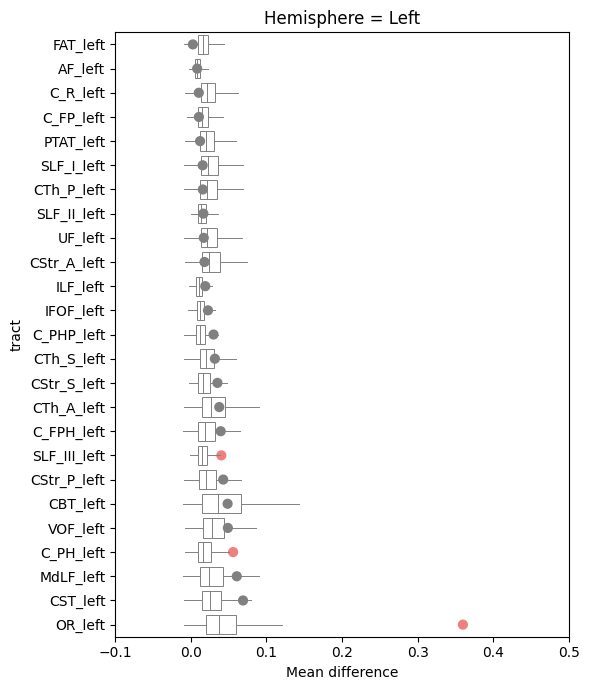

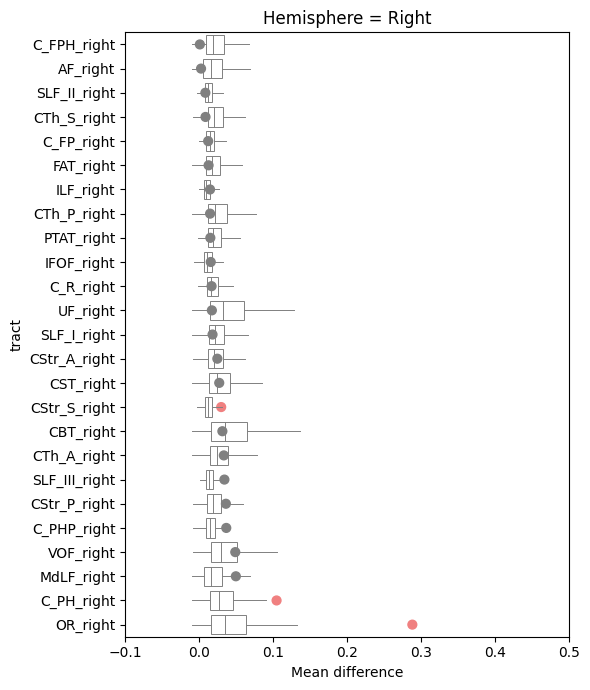

In [95]:
# Create a DataFrame from the results dictionary
result_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
result_df = result_df.rename(columns={'index': 'tract'})

# Ensure 'spin_mean_diff' is flattened for boxplots
result_df['spin_mean_diff'] = result_df['spin_mean_diff'].apply(lambda x: x.flatten())

# create hemisphere column
result_df['hemisphere'] = result_df['tract'].apply(lambda x: 'Left' if 'left' in x.lower() else 'Right')

##### make boxplots of empirical and null mean difference
for hemisphere in ['Left', 'Right']:
    
    # select hemisphere regression results
    hem_df = result_df.loc[result_df['hemisphere'] == hemisphere]
    
    # initialize figure
    fig, ax1 = plt.subplots(1, 1, figsize = (6, 7))
    
    # select empirical results
    diffData = hem_df['emp_mean_diff'].values
    sorted_idx = np.argsort(diffData)
    diffData = np.array(diffData)[sorted_idx] # sort by largest mean difference
    
    # select tract names
    tract_names = hem_df['tract'].values
#     n_features = len(tract_names)
    tract_names = np.array(tract_names)[sorted_idx]

    # select p-values
    pvalspin = hem_df['p_val'].values
#     p_fdr = hem_df['p_fdr_wholebrain'].values # for FDR corrected p-values on entire brain (50 tracts)
    pvalspin = np.array(pvalspin)[sorted_idx]
#     print(pvalspin)
    _, p_fdr, _, _ = multipletests(pvals = pvalspin, method = 'fdr_bh') # FDR correction for hemisphere (25 tracts)
    
    # select spin mean difference values and reformat data into long dataframe for seaborn boxplots
    tract_col = hem_df['tract'].reset_index(drop = True)[sorted_idx]
    null_mean_diff_col = hem_df['spin_mean_diff'].reset_index(drop = True)[sorted_idx]
    melted_df = pd.DataFrame({
        'tract': np.repeat(tract_col, null_mean_diff_col.apply(lambda x: len(x.flatten()))),
        'spin_mean_diff': np.concatenate([x.flatten() for x in null_mean_diff_col])
    })

    # plot empirical mean difference against null mean differences
    colors = np.where(pvalspin < 0.05, 'lightcoral', 'grey')
#     colors = np.where(p_fdr < 0.05, 'lightcoral', 'grey') # for corrected p-values
    
    # seaborn boxplot
    linewidth = 0.7
    sns.boxplot(x = 'spin_mean_diff', y = 'tract', data = melted_df, showfliers = False, showcaps = False,
            boxprops = dict(facecolor = 'none', edgecolor = 'grey', linewidth = linewidth),
            whiskerprops = dict(color = 'grey', linewidth = linewidth),
            medianprops = dict(color = 'grey', linewidth = linewidth))

    # matplotlib boxplot (cannot handle NaNs so not used here)
#     boxplot = ax1.boxplot(null_mean_diff.T, positions = range(len(diffData)), vert = False, showcaps = False, showfliers = False, 
#                           boxprops = dict(color = 'grey'), whiskerprops = dict(color='grey'))

    # Scatterplot of empirical mean differences
    ax1.scatter(diffData, range(len(diffData)), c = colors, s = 40) 

# #     ax1.set_yticks(range(len(diffData)))
    ax1.set_yticklabels(tract_names, rotation = 0)
    ax1.set_xlabel('Mean difference')
    ax1.set_xlim([-0.1, 0.5])
#     plt.grid(False)
    plt.title(f'Hemisphere = {hemisphere}')
    plt.tight_layout()
    plt.savefig(f'./outputs/ttests_similarity/{analysis}_{hemisphere}_meandiff_withnull.svg',
            bbox_inches = 'tight', dpi = 300,
            transparent = True)

 Only p-values smaller than 0.002 will survive FDR for 25 tracts (p-values). Here, before FDR the smallest p-values were around 0.009. 